In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.neighbors import KNeighborsClassifier
import gc

# Importing sklearn libraries
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import f1_score

# import lightgbm model
import lightgbm as lgb

plt.style.use('seaborn-darkgrid')
color = sns.color_palette()
%matplotlib inline

In [5]:
pwd

'D:\\Purdue\\2.Post-Arrival\\Events\\2021 10 29 - Tredence Hackathon\\Retail Recommender'

In [6]:
# Reading all the datasets from the csv_src folder
csv_folder = os.getcwd()
aisle = pd.read_csv( csv_folder+'\\Data\\For Code\\aisles.csv')
orders = pd.read_csv(csv_folder+'\\Data\\For Code\\orders.csv')
products = pd.read_csv(csv_folder+'\\Data\\For Code\\products.csv')
departments = pd.read_csv( csv_folder+'\\Data\\For Code\\departments.csv')
order_prior = pd.read_csv(csv_folder+'\\Data\\For Code\\order_products__prior.csv') 
order_train = pd.read_csv(csv_folder+'\\Data\\For Code\\train.csv')
order_test = pd.read_csv(csv_folder+'\\Data\\For Code\\test.csv')




In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
order_test.head()

,order_id,itemID,add_to_cart_order,userID,ID
0,1187899,13032,7,1,17
1,1187899,46149,11,1,11
2,1187899,26088,8,1,15
3,1492625,21329,31,2,119009
4,1492625,9387,10,2,65


In [9]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,ID
0,1187899,27845,9,0,1,14
1,1187899,38928,3,1,1,2
2,1187899,39657,5,1,1,21
3,1187899,26405,4,1,1,119001
4,1187899,196,1,1,1,10


In [10]:
order_train['user_id'].isin(orders['user_id']).value_counts()

True    787911
Name: user_id, dtype: int64

In [11]:
order_test = order_test.rename(columns={'userID': 'user_id', 'itemID': 'product_id'})

In [12]:
print(order_test['user_id'].count())
print(order_train['user_id'].count())

260664
787911


In [13]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [14]:
order_prior['order_id'].isin(orders['order_id']).value_counts()

True    32434489
Name: order_id, dtype: int64

In [15]:
order_prior['order_id'].nunique()

3214874

In [16]:
#print(orders['order_id'].nunique())
print(orders['user_id'].nunique())

206209


In [17]:
# Setting the correct indexes for the data sets

orders.set_index('order_id', inplace=True)
products.set_index('product_id', inplace=True)
aisle.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)
orders = orders.fillna(0) # Setting the NaNs to 0. i.e. sets the days since order to 0 for 1st orders

In [18]:
# Doing inner joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_comb = products.reset_index().set_index('department_id').join(departments, how="inner")
product_comb = product_comb.reset_index().set_index('aisle_id').join(aisle, how="inner")


In [19]:
# Setting the index to 'product_id' and sorting it
product_comb = product_comb.reset_index().set_index('product_id')
product_comb.sort_index(axis=0, ascending=True, kind='quicksort', inplace=True)

In [20]:
product_comb.head()
#print(product_comb.shape)

,aisle_id,department_id,product_name,department,aisle
product_id,,,,,
1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,104,13,All-Seasons Salt,pantry,spices seasonings
3,94,7,Robust Golden Unsweetened Oolong Tea,beverages,tea
4,38,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
5,5,13,Green Chile Anytime Sauce,pantry,marinades meat preparation


In [21]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [22]:
order_prior[(order_prior['order_id']==2168274) | (order_prior['order_id']==1501582)]


,order_id,product_id,add_to_cart_order,reordered
14228906,1501582,16797,1,0
14228907,1501582,47526,2,0
14228908,1501582,8479,3,0
14228909,1501582,47766,4,1
14228910,1501582,19051,5,0
14228911,1501582,8138,6,0
20554981,2168274,32792,1,0
20554982,2168274,47766,2,0
20554983,2168274,20574,3,0
20554984,2168274,12000,4,0


In [23]:
order_test[order_test['order_id']==1453977]
#print(order_test.shape)

,order_id,product_id,add_to_cart_order,user_id,ID
183630,1453977,45683,2,111018,850485


In [24]:
order_test['order_id'].isin(order_prior['order_id']).value_counts()

False    260664
Name: order_id, dtype: int64

In [25]:
order_test.head()

,order_id,product_id,add_to_cart_order,user_id,ID
0,1187899,13032,7,1,17
1,1187899,46149,11,1,11
2,1187899,26088,8,1,15
3,1492625,21329,31,2,119009
4,1492625,9387,10,2,65


In [26]:
order_prior.head()
order_prior.shape

(32434489, 4)

In [27]:
# Doing left joins on the products and the departments and the aisle by the department_id and aisle_id respectively
product_prior_comb = order_prior.set_index('product_id').join(product_comb, how="inner")
product_prior_comb.head()

,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,
1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9228,2,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,9273,30,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


## Checking all the input files

In [28]:
aisle.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [29]:
#orders.head()
#print(orders.shape)

#orders.set_index('order_id', inplace=True)
orders.head()
orders.shape

(3421083, 6)

In [30]:
#products.head()
print(products.shape)

(49688, 3)


In [31]:
departments.head()

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol


In [32]:
print(order_prior.head(), '\n\n')
print(product_prior_comb.head()) # added aisle id and dept id and name in order_prior table
print(order_prior.shape)

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0 


            order_id  add_to_cart_order  reordered  aisle_id  department_id  \
product_id                                                                    
1               1107                  7          0        61             19   
1               5319                  3          1        61             19   
1               7540                  4          1        61             19   
1               9228                  2          0        61             19   
1               9273                 30          0        61             19   

                          product_name department          aisle  
product_id                                          

In [33]:
order_train.head()
#print(order_train.shape)

,order_id,product_id,add_to_cart_order,reordered,user_id,ID
0,1187899,27845,9,0,1,14
1,1187899,38928,3,1,1,2
2,1187899,39657,5,1,1,21
3,1187899,26405,4,1,1,119001
4,1187899,196,1,1,1,10


In [34]:
order_test.head()

,order_id,product_id,add_to_cart_order,user_id,ID
0,1187899,13032,7,1,17
1,1187899,46149,11,1,11
2,1187899,26088,8,1,15
3,1492625,21329,31,2,119009
4,1492625,9387,10,2,65


In [35]:
# Completing the actual join operation with an inner join
product_train_comb = order_train.set_index('product_id').join(product_comb, how="inner")
print(product_prior_comb.shape, product_train_comb.shape)
product_train_comb.head(3)


product_test_comb = order_test.set_index('product_id').join(product_comb, how="inner")
print(product_test_comb.shape)
#product_test_comb.head(3)

(32434489, 8) (787911, 10)
(260664, 9)


In [36]:
#orders_train_filter = (orders['eval_set']=='train')
#orders_test_filter = (orders['eval_set']=='test')
train_set = orders[orders['eval_set']=='train']
test_set = orders[orders['eval_set']=='test']


train_set.head()
#train_set.shape

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1187899,1,train,11,4,8,14.0
1492625,2,train,15,1,11,30.0
2196797,5,train,5,0,11,6.0
525192,7,train,21,2,11,6.0
880375,8,train,4,1,14,10.0


In [37]:
product_train_comb.reset_index(inplace=True)
#product_train_comb.set_index('order_id')

orders_product_train_comb = pd.merge(train_set,product_train_comb, on= ['order_id', 'user_id'],how="inner")
orders_product_train_comb.head()

#product_test_comb.reset_index(inplace=True)
#product_train_comb.set_index('order_id')

#orders_product_test_comb = pd.merge(test_set,product_test_comb, on= ['order_id', 'user_id'],how="inner")
#orders_product_test_comb.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk


In [38]:
product_test_comb.reset_index(inplace=True)

orders_product_test_comb = pd.merge(test_set,product_test_comb, on= ['order_id', 'user_id'],how="inner")
orders_product_test_comb.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,ID,aisle_id,department_id,product_name,department,aisle


In [39]:
product_train_comb.head()

,product_id,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle
0,1,63770,4,0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,6695,7,1,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,1,767323,5,0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,1,304053,3,1,9694,2852,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,1,1028477,2,0,13916,150015,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [40]:
orders_product_train_comb[orders_product_train_comb['user_id']==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk
5,1187899,1,train,11,4,8,14.0,38928,3,1,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt
6,1187899,1,train,11,4,8,14.0,39657,5,1,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate
7,1187899,1,train,11,4,8,14.0,49235,10,1,12,53,16,Organic Half & Half,dairy eggs,cream


In [41]:
test_set.head(3)

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2774568,3,test,13,5,15,11.0
329954,4,test,6,3,12,30.0
1528013,6,test,4,3,16,22.0


In [42]:
product_test_comb.head()

,product_id,order_id,add_to_cart_order,user_id,ID,aisle_id,department_id,product_name,department,aisle
0,1,253400,4,21054,70466,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,2795830,1,29911,269483,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,1,1845054,11,31260,315191,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,1,1897200,24,35890,236479,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,1,704249,2,37537,321162,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [43]:
orders[orders['user_id'] == 4]

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
3343014,4,prior,1,6,11,0.0
2030307,4,prior,2,4,11,19.0
691089,4,prior,3,4,15,21.0
94891,4,prior,4,5,13,15.0
2557754,4,prior,5,5,13,0.0
329954,4,test,6,3,12,30.0


In [44]:
order_train[order_train['user_id'] == 84549]

,order_id,product_id,add_to_cart_order,reordered,user_id,ID
426987,2499127,39332,23,1,84549,527023
426988,2499127,33783,18,1,84549,527068
426989,2499127,21573,22,1,84549,527032
426990,2499127,17122,10,1,84549,527126
426991,2499127,6184,4,1,84549,525077
426992,2499127,39275,20,1,84549,527047
426993,2499127,16974,15,1,84549,527087
426994,2499127,10441,14,1,84549,527094
426995,2499127,11759,19,1,84549,527058
426996,2499127,39657,7,1,84549,527151


In [45]:
product_train_comb.head()

,product_id,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle
0,1,63770,4,0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,6695,7,1,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,1,767323,5,0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,1,304053,3,1,9694,2852,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,1,1028477,2,0,13916,150015,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [46]:
product_test_comb[product_test_comb['user_id']==84549]

,product_id,order_id,add_to_cart_order,user_id,ID,aisle_id,department_id,product_name,department,aisle
9,1,2499127,17,84549,527075,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
58211,12341,2499127,5,84549,527167,32,4,Hass Avocados,produce,packaged produce
104427,21288,2499127,12,84549,527110,24,4,Blackberries,produce,fresh fruits
133587,26088,2499127,24,84549,527015,23,19,Aged White Cheddar Popcorn,snacks,popcorn jerky
136859,26569,2499127,21,84549,527039,24,4,Braeburn Apples,produce,fresh fruits
194681,37710,2499127,11,84549,527119,125,19,Trail Mix,snacks,trail mix snack mix
258437,49235,2499127,25,84549,527008,53,16,Organic Half & Half,dairy eggs,cream


In [47]:
#product_test_comb.insert(loc=3, column='reordered', value='test')
product_test_comb.reset_index(inplace=True)

In [48]:
product_test_comb.head()

,index,product_id,order_id,add_to_cart_order,user_id,ID,aisle_id,department_id,product_name,department,aisle
0,0,1,253400,4,21054,70466,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,1,2795830,1,29911,269483,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,2,1,1845054,11,31260,315191,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,3,1,1897200,24,35890,236479,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,4,1,704249,2,37537,321162,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


### Test train data creation

In [49]:
frames = [product_train_comb,product_test_comb]

test_train_data_prod = pd.concat(frames)
test_train_data_prod.head()

,product_id,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle,index
0,1,63770,4,0.0,751,15342,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,NaN
1,1,6695,7,1.0,1540,87295,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,NaN
2,1,767323,5,0.0,2221,22604,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,NaN
3,1,304053,3,1.0,9694,2852,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,NaN
4,1,1028477,2,0.0,13916,150015,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes,NaN


In [50]:
print(product_train_comb.shape)
print(product_test_comb.shape)
print(test_train_data_prod.shape)

(787911, 11)
(260664, 11)
(1048575, 12)


In [51]:
test_train_data_prod[test_train_data_prod['user_id']==84549].sort_values(by=['add_to_cart_order'])

,product_id,order_id,add_to_cart_order,reordered,user_id,ID,aisle_id,department_id,product_name,department,aisle,index
245995,16953,2499127,1,1.0,84549,526985,88,13,Creamy Peanut Butter,pantry,spreads,NaN
420724,26932,2499127,2,1.0,84549,526978,17,13,Turbinado Cane Sugar,pantry,baking ingredients,NaN
199538,13575,2499127,3,1.0,84549,526970,24,4,Apples,produce,fresh fruits,NaN
89017,6184,2499127,4,1.0,84549,525077,32,4,Clementines,produce,packaged produce,NaN
58211,12341,2499127,5,NaN,84549,527167,32,4,Hass Avocados,produce,packaged produce,58211.0
676676,43352,2499127,6,1.0,84549,527158,32,4,Raspberries,produce,packaged produce,NaN
619261,39657,2499127,7,1.0,84549,527151,45,19,Milk Chocolate Almonds,snacks,candy chocolate,NaN
242678,16797,2499127,8,1.0,84549,527143,24,4,Strawberries,produce,fresh fruits,NaN
237364,16539,2499127,9,1.0,84549,527135,113,1,Orange Juice with Calcium,frozen,frozen juice,NaN
248251,17122,2499127,10,1.0,84549,527126,24,4,Honeycrisp Apples,produce,fresh fruits,NaN


### Final Test train data for Modelling

In [52]:
test_train_final = pd.merge(train_set,test_train_data_prod, on= ['order_id', 'user_id'],how="inner")
test_train_final.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index
0,1187899,1,train,11,4,8,14.0,196,1,1.0,10,77,7,Soda,beverages,soft drinks,NaN
1,1187899,1,train,11,4,8,14.0,10258,6,1.0,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN
2,1187899,1,train,11,4,8,14.0,25133,2,1.0,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN
3,1187899,1,train,11,4,8,14.0,26405,4,1.0,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN
4,1187899,1,train,11,4,8,14.0,27845,9,0.0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN


In [53]:
test_train_final[test_train_final['user_id']==84549]
#test_train_final.shape


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index
568138,2499127,84549,train,55,1,9,7.0,3798,16,1.0,527080,24,4,Pink Lady Apples,produce,fresh fruits,NaN
568139,2499127,84549,train,55,1,9,7.0,6184,4,1.0,525077,32,4,Clementines,produce,packaged produce,NaN
568140,2499127,84549,train,55,1,9,7.0,9434,13,1.0,527103,34,1,Bag of Large Lemons,frozen,frozen meat seafood,NaN
568141,2499127,84549,train,55,1,9,7.0,10326,27,1.0,526992,24,4,Organic Fuji Apples,produce,fresh fruits,NaN
568142,2499127,84549,train,55,1,9,7.0,10441,14,1.0,527094,117,19,Dry Roasted Almonds,snacks,nuts seeds dried fruit,NaN
568143,2499127,84549,train,55,1,9,7.0,11759,19,1.0,527058,107,19,Organic Simply Naked Pita Chips,snacks,chips pretzels,NaN
568144,2499127,84549,train,55,1,9,7.0,13575,3,1.0,526970,24,4,Apples,produce,fresh fruits,NaN
568145,2499127,84549,train,55,1,9,7.0,16539,9,1.0,527135,113,1,Orange Juice with Calcium,frozen,frozen juice,NaN
568146,2499127,84549,train,55,1,9,7.0,16797,8,1.0,527143,24,4,Strawberries,produce,fresh fruits,NaN
568147,2499127,84549,train,55,1,9,7.0,16953,1,1.0,526985,88,13,Creamy Peanut Butter,pantry,spreads,NaN


In [54]:
product_prior_comb[product_prior_comb['order_id']==1107]

,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
product_id,,,,,,,,
1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
769,1107,10,0,21,16,Sliced American Cheese,dairy eggs,packaged cheese
6184,1107,14,1,32,4,Clementines,produce,packaged produce
8048,1107,15,1,32,4,Packaged Grape Tomatoes,produce,packaged produce
9007,1107,17,0,121,14,Frosted Flakes,breakfast,cereal
9434,1107,2,0,34,1,Bag of Large Lemons,frozen,frozen meat seafood
12078,1107,9,0,21,16,Shredded Mexican Blend Cheese,dairy eggs,packaged cheese
13176,1107,3,1,24,4,Bag of Organic Bananas,produce,fresh fruits
16797,1107,1,1,24,4,Strawberries,produce,fresh fruits


In [55]:
product_prior_comb.reset_index(inplace=True)
product_prior_comb.head()

,product_id,order_id,add_to_cart_order,reordered,aisle_id,department_id,product_name,department,aisle
0,1,1107,7,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
1,1,5319,3,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
2,1,7540,4,1,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
3,1,9228,2,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes
4,1,9273,30,0,61,19,Chocolate Sandwich Cookies,snacks,cookies cakes


In [56]:
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [57]:
# keeping only training data
final_train_valid=test_train_final[(test_train_final.reordered == 1.0) | (test_train_final.reordered == 0.0)]
print(final_train_valid.shape)

(787911, 17)


In [58]:
final_train_valid = final_train_valid.astype({"reordered": int})
final_train_valid.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks,NaN
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN


In [59]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to lowest possible float without data loss
                `int64`   type to lowest possible int wihtout data loss
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

    del float_cols
    del int_cols
    
    return df

In [60]:
final_train_valid = downcast_dtypes(final_train_valid)
gc.collect()

48

In [61]:
final_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 787911 entries, 0 to 1048573
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                787911 non-null  int32  
 1   user_id                 787911 non-null  int32  
 2   eval_set                787911 non-null  object 
 3   order_number            787911 non-null  int8   
 4   order_dow               787911 non-null  int8   
 5   order_hour_of_day       787911 non-null  int8   
 6   days_since_prior_order  787911 non-null  float32
 7   product_id              787911 non-null  int32  
 8   add_to_cart_order       787911 non-null  int8   
 9   reordered               787911 non-null  int32  
 10  ID                      787911 non-null  int32  
 11  aisle_id                787911 non-null  int16  
 12  department_id           787911 non-null  int8   
 13  product_name            787911 non-null  object 
 14  department         

In [62]:
final_train_valid.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks,NaN
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN


In [65]:
gc.collect()

0

## Model Training  - LightGBM

In [66]:
################################################################################
#############Splitting training data into Train and Validation sets#############
################################################################################

In [67]:
# getting count of products in each order
count=final_train_valid.groupby(['user_id', 'order_id'])['ID'].count().rename('product_count')
final_train_valid = pd.merge(final_train_valid, count, on=['user_id', 'order_id'], how='left')
final_train_valid.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index,product_count
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks,NaN,8
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN,8
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN,8
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN,8
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8


In [68]:
# getting cum sum for each order id
final_train_valid['product_running_count'] = final_train_valid.groupby(['user_id', 'order_id'])['product_count'].cumsum()
final_train_valid.head(40)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index,product_count,product_running_count
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks,NaN,8,8
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN,8,16
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN,8,24
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN,8,32
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8,40
5,1187899,1,train,11,4,8,14.0,38928,3,1,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt,NaN,8,48
6,1187899,1,train,11,4,8,14.0,39657,5,1,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate,NaN,8,56
7,1187899,1,train,11,4,8,14.0,49235,10,1,12,53,16,Organic Half & Half,dairy eggs,cream,NaN,8,64
8,1492625,2,train,15,1,11,30.0,1757,30,0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon,NaN,23,23
9,1492625,2,train,15,1,11,30.0,2361,26,0,31,37,1,Mint Chip,frozen,ice cream ice,NaN,23,46


In [69]:
# getting running count for each order
final_train_valid['product_running_count'] = final_train_valid['product_running_count'] / final_train_valid['product_count']
final_train_valid.head(40)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index,product_count,product_running_count
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks,NaN,8,1.0
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN,8,2.0
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN,8,3.0
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN,8,4.0
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8,5.0
5,1187899,1,train,11,4,8,14.0,38928,3,1,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt,NaN,8,6.0
6,1187899,1,train,11,4,8,14.0,39657,5,1,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate,NaN,8,7.0
7,1187899,1,train,11,4,8,14.0,49235,10,1,12,53,16,Organic Half & Half,dairy eggs,cream,NaN,8,8.0
8,1492625,2,train,15,1,11,30.0,1757,30,0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon,NaN,23,1.0
9,1492625,2,train,15,1,11,30.0,2361,26,0,31,37,1,Mint Chip,frozen,ice cream ice,NaN,23,2.0


In [70]:
# getting percentage of rows
final_train_valid['product_count_percent'] = final_train_valid['product_running_count'] / final_train_valid['product_count']
final_train_valid.head(40)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index,product_count,product_running_count,product_count_percent
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks,NaN,8,1.0,0.125000
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN,8,2.0,0.250000
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN,8,3.0,0.375000
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN,8,4.0,0.500000
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8,5.0,0.625000
5,1187899,1,train,11,4,8,14.0,38928,3,1,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt,NaN,8,6.0,0.750000
6,1187899,1,train,11,4,8,14.0,39657,5,1,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate,NaN,8,7.0,0.875000
7,1187899,1,train,11,4,8,14.0,49235,10,1,12,53,16,Organic Half & Half,dairy eggs,cream,NaN,8,8.0,1.000000
8,1492625,2,train,15,1,11,30.0,1757,30,0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon,NaN,23,1.0,0.043478
9,1492625,2,train,15,1,11,30.0,2361,26,0,31,37,1,Mint Chip,frozen,ice cream ice,NaN,23,2.0,0.086957


In [71]:
# training data
lgtrain = final_train_valid[(final_train_valid.product_count_percent <= 0.7)]
lgtrain.head(40)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index,product_count,product_running_count,product_count_percent
0,1187899,1,train,11,4,8,14.0,196,1,1,10,77,7,Soda,beverages,soft drinks,NaN,8,1.0,0.125000
1,1187899,1,train,11,4,8,14.0,10258,6,1,19,117,19,Pistachios,snacks,nuts seeds dried fruit,NaN,8,2.0,0.250000
2,1187899,1,train,11,4,8,14.0,25133,2,1,9,21,16,Organic String Cheese,dairy eggs,packaged cheese,NaN,8,3.0,0.375000
3,1187899,1,train,11,4,8,14.0,26405,4,1,119001,54,17,XL Pick-A-Size Paper Towel Rolls,household,paper goods,NaN,8,4.0,0.500000
4,1187899,1,train,11,4,8,14.0,27845,9,0,14,84,16,Organic Whole Milk,dairy eggs,milk,NaN,8,5.0,0.625000
8,1492625,2,train,15,1,11,30.0,1757,30,0,23,69,15,Organic Cashew Carrot Ginger Soup,canned goods,soup broth bouillon,NaN,23,1.0,0.043478
9,1492625,2,train,15,1,11,30.0,2361,26,0,31,37,1,Mint Chip,frozen,ice cream ice,NaN,23,2.0,0.086957
10,1492625,2,train,15,1,11,30.0,5699,22,0,39,38,1,Gluten Free Mushroom Risotto Bowl,frozen,frozen meals,NaN,23,3.0,0.130435
11,1492625,2,train,15,1,11,30.0,11913,28,0,27,117,19,Shelled Pistachios,snacks,nuts seeds dried fruit,NaN,23,4.0,0.173913
12,1492625,2,train,15,1,11,30.0,12007,15,0,54,80,11,Organic All Day Fresh Deodorant Lavender,personal care,deodorants,NaN,23,5.0,0.217391


In [72]:
# training data
lgval = final_train_valid[(final_train_valid.product_count_percent > 0.7)]
lgval.head(40)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index,product_count,product_running_count,product_count_percent
5,1187899,1,train,11,4,8,14.0,38928,3,1,2,120,16,0% Greek Strained Yogurt,dairy eggs,yogurt,NaN,8,6.0,0.750000
6,1187899,1,train,11,4,8,14.0,39657,5,1,21,45,19,Milk Chocolate Almonds,snacks,candy chocolate,NaN,8,7.0,0.875000
7,1187899,1,train,11,4,8,14.0,49235,10,1,12,53,16,Organic Half & Half,dairy eggs,cream,NaN,8,8.0,1.000000
24,1492625,2,train,15,1,11,30.0,38547,13,0,58,46,19,Bubblegum Flavor Natural Chewing Gum,snacks,mint gum,NaN,23,17.0,0.739130
25,1492625,2,train,15,1,11,30.0,41787,5,1,75,24,4,Bartlett Pears,produce,fresh fruits,NaN,23,18.0,0.782609
26,1492625,2,train,15,1,11,30.0,45066,9,1,67,24,4,Honeycrisp Apple,produce,fresh fruits,NaN,23,19.0,0.826087
27,1492625,2,train,15,1,11,30.0,45613,18,1,48,38,1,Pad Thai,frozen,frozen meals,NaN,23,20.0,0.869565
28,1492625,2,train,15,1,11,30.0,45645,29,0,25,3,19,Dark Chocolate Nuts & Sea Salt Bars,snacks,energy granola bars,NaN,23,21.0,0.913043
29,1492625,2,train,15,1,11,30.0,48523,25,0,33,37,1,Birthday Cake Light Ice Cream,frozen,ice cream ice,NaN,23,22.0,0.956522
30,1492625,2,train,15,1,11,30.0,48821,27,0,29,37,1,Pistachio Ice Cream,frozen,ice cream ice,NaN,23,23.0,1.000000


In [73]:
print(lgtrain.shape)

(504120, 20)


In [74]:
print(lgval.shape)

(283791, 20)


In [75]:
lgtraindata = lgb.Dataset(lgtrain.drop(['eval_set', 'order_id','user_id','ID','product_name','department','aisle','index','product_count','product_running_count','product_count_percent','reordered'], axis=1).to_numpy(), label=lgtrain['reordered'].to_numpy())
lgvaldata = lgb.Dataset(lgval.drop(['eval_set', 'order_id','user_id','ID','product_name','department','aisle','index','product_count','product_running_count','product_count_percent','reordered'], axis=1).to_numpy(), label=lgval['reordered'].to_numpy())

In [76]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def run_lgb(depth, leaves):
    params = {
        'objective' : 'binary',
        'boosting_type':'gbdt',
        'num_leaves' : leaves,
        'learning_rate' : 0.02,
        'feature_fraction' : 0.8,
        'bagging_seed' : 42,
        'seed': 42,
        'max_depth': depth, 
        'verbose': 0, 
        'num_boost_round':5000, 
        'early_stopping_rounds':200, 
    }

    evals_result = {}
    model = lgb.train(params, lgtraindata, num_boost_round=params['num_boost_round'], 
                      valid_sets=[lgtraindata, lgvaldata], 
                      early_stopping_rounds=params['early_stopping_rounds'], 
                      verbose_eval=150, 
                      evals_result=evals_result, feval=lgb_f1_score)
    
    return model, evals_result

In [77]:
# running model for depth 5 (and leaves 10)
lgb_5_10, evals_result_5_10 = run_lgb(5,10)

C:\Users\vohra\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vohra\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
[150]	training's binary_logloss: 0.603202	training's f1: 0.759239	valid_1's binary_logloss: 0.607209	valid_1's f1: 0.759592
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.623217	training's f1: 0.76557	valid_1's binary_logloss: 0.625673	valid_1's f1: 0.764329


In [78]:
# running model for depth 7 (and leaves 10)
lgb_7_10, evals_result_7_10 = run_lgb(7,10)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036698 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[150]	training's binary_logloss: 0.60276	training's f1: 0.75936	valid_1's binary_logloss: 0.607015	valid_1's f1: 0.759401
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.621901	training's f1: 0.765387	valid_1's binary_logloss: 0.624455	valid_1's f1: 0.764235


In [79]:
# re-run model without the validation data

def run_lgb_nov(depth, leaves):
    params = {
        'objective' : 'binary',
        'boosting_type':'gbdt',
        'num_leaves' : leaves,
        'learning_rate' : 0.02,
        'feature_fraction' : 0.8,
        'bagging_seed' : 42,
        'seed': 42,
        'max_depth': depth, 
        'verbose': 0, 
        'num_boost_round':5000
    }

    evals_result = {}
    model = lgb.train(params, lgtraindata_full, num_boost_round=params['num_boost_round'])
    
    return model

In [80]:
# full training data
lgtraindata_full = lgb.Dataset(final_train_valid.drop(['eval_set', 'order_id','user_id','ID','product_name','department','aisle','index','product_count','product_running_count','product_count_percent','reordered'], axis=1).to_numpy(), label=final_train_valid['reordered'].to_numpy())

In [81]:
# running full model for depth 5 (and leaves 10)
lgb_5_10_full = run_lgb_nov(5,10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [82]:
# readying test data
final_test_valid_1 = test_train_final[(test_train_final.reordered != 1.0) & (test_train_final.reordered != 0.0)]
print(final_test_valid_1.shape)

(260664, 17)


In [83]:
final_test_valid_1.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,ID,aisle_id,department_id,product_name,department,aisle,index
8,1187899,1,train,11,4,8,14.0,13032,7,NaN,17,121,14,Cinnamon Toast Crunch,breakfast,cereal,61298.0
9,1187899,1,train,11,4,8,14.0,26088,8,NaN,15,23,19,Aged White Cheddar Popcorn,snacks,popcorn jerky,133565.0
10,1187899,1,train,11,4,8,14.0,46149,11,NaN,11,77,7,Zero Calorie Cola,beverages,soft drinks,239180.0
34,1492625,2,train,15,1,11,30.0,5450,11,NaN,62,24,4,Small Hass Avocado,produce,fresh fruits,24365.0
35,1492625,2,train,15,1,11,30.0,7963,2,NaN,81,58,1,Gluten Free Whole Grain Bread,frozen,frozen breads doughs,36631.0


In [84]:
final_test_valid=final_test_valid_1.drop(['eval_set', 'order_id','user_id','ID','product_name','department','aisle','index','reordered'], axis=1)

In [85]:
final_test_valid = downcast_dtypes(final_test_valid)
gc.collect()

63

In [86]:
final_test_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260664 entries, 8 to 1048574
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_number            260664 non-null  int8   
 1   order_dow               260664 non-null  int8   
 2   order_hour_of_day       260664 non-null  int8   
 3   days_since_prior_order  260664 non-null  float32
 4   product_id              260664 non-null  int32  
 5   add_to_cart_order       260664 non-null  int8   
 6   aisle_id                260664 non-null  int16  
 7   department_id           260664 non-null  int8   
dtypes: float32(1), int16(1), int32(1), int8(5)
memory usage: 5.7 MB


In [87]:
# Making predictions
y_test = lgb_5_10_full.predict(final_test_valid.to_numpy())

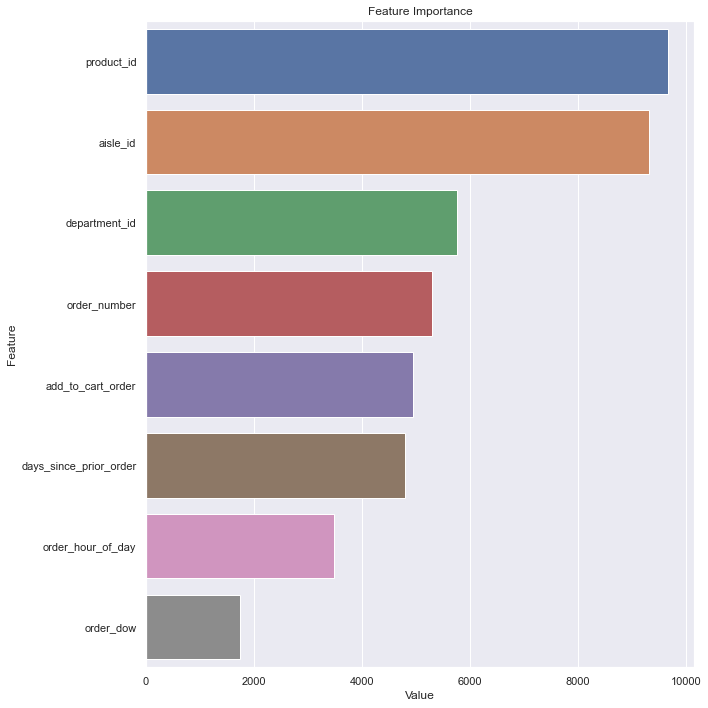

In [88]:
# plot feature importance
feature_imp = pd.DataFrame({'Value':lgb_5_10_full.feature_importance(),'Feature':final_test_valid.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale = 1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:30])
plt.title('Feature Importance')
plt.savefig(csv_folder+'\\Data\\For Code\\lgbm_importances-01.png')
plt.tight_layout()
plt.show()

In [89]:
y_test.shape

(260664,)

In [95]:
y_test

array([0.65085091, 0.62767309, 0.62092905, ..., 0.53642962, 0.48890856,
       0.90767344])

In [96]:
# converting predictions to pandas dataframe
y_test_pd = pd.DataFrame({'reordered': y_test[:,]})
y_test_pd.head()

,reordered
0,0.650851
1,0.627673
2,0.620929
3,0.591142
4,0.728051


In [97]:
submission = final_test_valid_1['ID'].reset_index()
submission.head()

,index,ID
0,8,17
1,9,15
2,10,11
3,34,62
4,35,81


In [98]:
submission['reordered']=y_test_pd
submission.head()

,index,ID,reordered
0,8,17,0.650851
1,9,15,0.627673
2,10,11,0.620929
3,34,62,0.591142
4,35,81,0.728051


In [99]:
submission.loc[submission['reordered'] >=0.5, 'reordered'] = 1
submission.loc[submission['reordered'] < 0.5, 'reordered'] = 0
submission['reordered'].value_counts()

1.0    172612
0.0     88052
Name: reordered, dtype: int64

In [100]:
test_file = order_test[['ID']]
#test_file.head()

In [101]:
final_submission_2 = pd.merge(test_file,submission[['reordered', 'ID']], on=['ID'], how='left')
final_submission_2.head()

,ID,reordered
0,17,1.0
1,11,1.0
2,15,1.0
3,119009,0.0
4,65,1.0


In [102]:
final_submission_3 = final_submission_2[['reordered', 'ID']]
final_submission_3.value_counts()

reordered  ID     
1.0        1382635    1
0.0        1316844    1
           1317192    1
           1317174    1
           1317134    1
                     ..
1.0        521143     1
           521127     1
           521125     1
           521124     1
0.0        35         1
Length: 260664, dtype: int64

In [104]:
final_submission_3.to_csv(csv_folder+'\\Submissions\\recommender_submission_1.csv',index=False)